# 1.Introduction
我在数据科学领域很陌生，特别是变压器对我来说是一个非常新的概念。在我探索更多关于BERT的知识时，我注意到kaggle上的大部分材料要么讨论BERT模型中的底层逻辑和模块（这对初学者来说是必要的），要么提供没有太多细节的代码块。这份材料试图弥合从BERT模型的基础和理论到简单模型实用性的差距。

这本笔记本中的许多工作都是受这本笔记本中chumajin工作的启发。我想在这里感谢他，并补充说，我已经使其适应了我们在这次比赛中的问题。我还添加了更多的可视化，以查看模型在不同时代和不同褶皱的迭代中的影响。

## 1.1 Objective
创建一个模型，预测每个评论的每种毒性的概率。

本笔记本分为两部分。由于kaggle中的内存限制，我将其分成两部分。您可以独立运行第一部分或第二部分。

在第一部分中，我试图解释我们处理类似任务需要采取的主要步骤，对于不同标签的二分类。这部分中的模型仅适用于训练集和验证集的一个分布。你可以看到我们从这个模型中得到的初始性能结果（auc分数）。

在第二部分中，我已经从第一部分中列出了所有必要的代码块，然后展示了如何为k_fold（k=5）中的训练集和验证集的不同选择开发5个模型。然后将每个评论的所有类型毒性的概率估计为这5个模型的平均值。

## 1.2 Parameters affecting simulation time
为了快速运行这个笔记本，看看它是如何工作的，在第一部分和第二部分，您可以将训练集减少到有限的行数。我在第一部分中取了200行，在第二部分中取了2000行。

在第一部分中它非常低的原因是代码选择了教育原因而不是效率。因此，它读取了许多不同的变量，如果我们超过200行，就会导致cuda内存崩溃。这给我们第一部分的结果并不令人印象深刻（准确率86%）

在第二部分中，代码比第一部分更方便，并且可以增加行数以包含整个训练集。但是，我将其限制在2000，因此您可以在22分钟的模拟中获得相当好的结果（94%的准确率和0.988 auc分数）。

你可以有(epochs = 5, k = 5) ，看看不同纪元的精度和损耗是如何影响的。精度和损耗在可接受的范围内，因为这本笔记本不关心达到最先进的结果。

# PART 1
# 2.Prepare the data
## 2.1 Loading libraries

In [2]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 我们为结果的可重复性播下了seed。
SEED = 34

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

In [4]:
train = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/train.csv', nrows = 200 )
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
temp = train[train['toxic'] == 1]
temp.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [6]:
# 打印了train数据集中 'comment_text' 列的第10个样本的字符总数。
print(len(train['comment_text'][10]), 'Total Characters')
# 使用 train['comment_text'][10] 来访问 train 数据集中 'comment_text' 列的第10个样本。
train['comment_text'][10]

2875 Total Characters


'"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such a

In [7]:
# 一条评论可以同时有毒、severe_toxic、淫秽和侮辱。所以每个评论的类别不限于一个。
# 现在让我们检查训练数据集中每一列的值。

# 从训练数据集中删除 'id' 和 'comment_text' 列，得到一个新的DataFrame对象 labels，其中包含了除了这两列之外的所有列。
labels = train.drop(['id', 'comment_text'], axis = 1)
# 定义了一个名为 unique_values 的 lambda 函数，该函数接受一个参数 x，并返回 train[x] 列的独特值。
unique_values = lambda x: train[x].unique()
# 遍历 labels DataFrame 的所有列。对于每一列，代码调用 unique_values 函数，并将结果收集到一个列表中。
[unique_values(col) for col in labels.columns.tolist()]

[array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1])]

In [8]:
test = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/test.csv', nrows = 100)
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
test_labels = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/test_labels.csv', nrows = 10)
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [10]:
submission = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/sample_submission.csv', nrows = 10)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


# 3.Summerize data
## 3.1 Descriptive statistics

In [11]:
# Missing values
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [12]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [13]:
# 太好了！我们没有缺失的商品了！
# 训练集和测试标签中每个类的分布
# 让我们检查一下在我们的训练数据中每个类别有多少

# 从训练数据集中删除 'id' 和 'comment_text' 列，得到一个新的DataFrame对象 df_train，其中包含了除了这两列之外的所有列。
df_train = train.drop(['id', 'comment_text'], axis = 1)
# 对 df_train 的每列进行求和操作，得到每个标签的计数值。这将返回一个Series对象，其中索引是标签列的名称，值是对应列的计数值。
label_counts = df_train.sum()
# 将计数值转换为DataFrame对象，并将列名设置为 'counts'。
df_counts = pd.DataFrame(label_counts)
# 将列名 0 更改为 'counts'。
df_counts.rename(columns = {0:'counts'}, inplace = True)
# 对DataFrame对象 df_counts 按计数值从大到小进行排序。
df_counts = df_counts.sort_values('counts', ascending = False)
df_counts 

,counts
toxic,20
insult,12
obscene,11
severe_toxic,3
identity_hate,3
threat,2


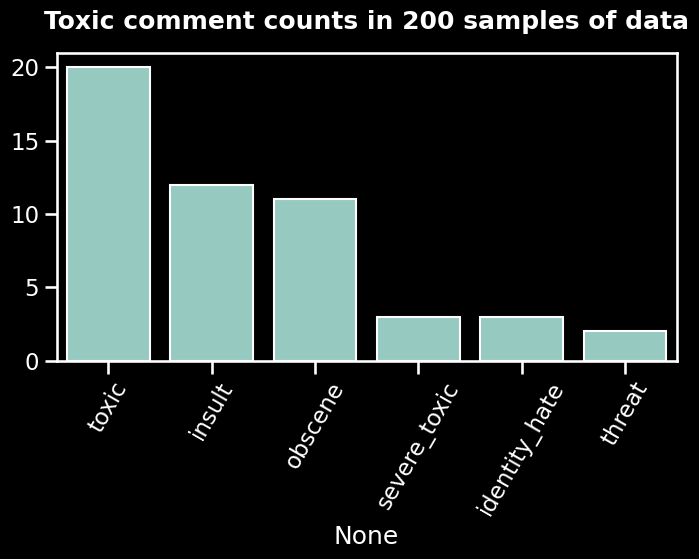

In [14]:
# 创建了一个新的图形对象 fig 和一个坐标轴对象 ax。figsize=(8, 4) 指定了图形的尺寸为宽度 8 英寸、高度 4 英寸。
fig, ax = plt.subplots(figsize = (8,4))
# 创建了一个垂直条形图。x=df_counts.index 指定了 x 轴的数据，即标签列的名称，
# y=df_counts['counts'] 指定了 y 轴的数据，即标签列的计数值。函数的返回值 p 是一个表示绘制的条形图的对象。
p = sns.barplot(x=df_counts.index, y=df_counts['counts'])
# 使用 plt.xticks() 函数旋转 x 轴刻度标签，使其以 60 度的角度显示。
x = plt.xticks(rotation = 60) 
# 设置图形的标题。标题文本由字符串 'Toxic comment counts in '、训练数据集的样本数 len(df_train) 和字符串 ' samples of data' 组成。
# weight='bold' 和 fontsize=18 设置标题的字体样式和大小，y=1.05 控制标题的垂直位置。
ax.set_title('Toxic comment counts in '+ str(len(df_train))+ ' samples of data', weight = 'bold', fontsize = 18, y = 1.05)
# 将 y 轴的标签设为空字符串，即不显示 y 轴的标签。
x = ax.set_ylabel('')

In [15]:
# 相对百分比让我们更好地理解。
# 将每个标签的计数值除以样本数，并乘以 100，得到了每个标签的相对百分比
labels = np.round(df_train.sum()/len(df_train)*100, 1)
labels

toxic            10.0
severe_toxic      1.5
obscene           5.5
threat            1.0
insult            6.0
identity_hate     1.5
dtype: float64

In [16]:
# 从测试数据集中删除 'id' 列，并将结果存储在 df_test_labels 变量中
df_test_labels = test_labels.drop(['id'], axis = 1)
# 对 df_test_labels 的每一列应用 count_values 函数，从而计算每个标签列的相对百分比。
count_values = lambda x: np.round(df_test_labels[x].value_counts(normalize = True)*100, 1)
# 使用 pd.DataFrame() 将计算结果转换为一个DataFrame对象，其中每一行表示一个标签列，每一列表示相对百分比。
pd.DataFrame([count_values(col) for col in df_test_labels.columns.tolist()])

,-1,0
proportion,80.0,20.0
proportion,80.0,20.0
proportion,80.0,20.0
proportion,80.0,20.0
proportion,80.0,20.0
proportion,80.0,20.0


In [17]:
train.shape, test.shape

((200, 8), (100, 2))

# 4.Prepare Data
## 4.1 Data cleaning
我们需要对数据进行清理、标记化并将其转换为张量。  
下面的函数可以帮助我们：  
    删除超链接、标点符号和数字  
    标记化  
我们跳过将其全部更改为小写字母，并保持字母对大小写敏感。评论BAD！！其中的负面情绪比坏情绪更强烈！！  
我们也不会删除停用词，因为对于像BERT和ROBERTA这样的上下文模型，最好不要处理删除停用词的文本。这些模型是用停用词预先训练的：如果你删除停用词，你的模型可能会丢失上下文。词干和词法化预处理技术也是如此。所以我们也跳过它们！

In [18]:
# text preprocessing helper functions [1]

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    #text = text.lower()
    
    #pattern = [zero or more character]
    text = re.sub('\[.*?\]', '', text)
    
    #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #pattern = <, zero or more characters, >, (one or more occurance of >)
    text = re.sub('<.*?>+', '', text)
    
    #pattern = any punctionation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    #pattern = any new line
    text = re.sub('\n', '', text)
    
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
    text = re.sub('\w*\d\w*', '', text)
    return text

In [19]:
%%time
train['clean_text'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
test['clean_text'] = test['comment_text'].apply(str).apply(lambda x: clean_text(x))
# %%time 是一种单元魔术命令，用于测量多行代码（代码单元）的执行时间。它会在执行整个代码单元后返回执行时间的结果。
# 分别访问训练数据集和测试数据集中的 'comment_text' 列，这里使用 apply(str) 将列中的元素转换为字符串类型。
# 对每个字符串元素应用一个匿名函数。这个匿名函数调用了名为 clean_text 的函数，并将每个字符串作为参数传递给它。

CPU times: user 60.8 ms, sys: 0 ns, total: 60.8 ms
Wall time: 59.7 ms


## 4.2 Dataset and Dataloader

In [20]:
# 我们使用20%的训练数据作为验证集。
kfold = 5
# 使用 train.index % kfold 计算每个样本在数据集中的索引值与 kfold 取模的结果。
# 这个操作会生成一个包含与数据集索引对应的折叠编号的 Series 对象。
train['kfold'] = train.index % kfold
# train.index 表示训练数据集的索引，而 % 是取模运算符，用于计算索引与 kfold 的模。
# 这样，对于索引为 i 的样本，i % kfold 的结果将是 0 到 4 之间的整数，对应着 5 个折叠中的一个。
train.index % kfold

Index([0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
       ...
       0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
      dtype='int64', length=200)

In [21]:
# reset_index创建一个名为'index'的列，并将旧的索引值保存在其中并更新index的值。
# drop=True删除具有旧索引值的列“索引”。
p_train = train[train["kfold"] != 0].reset_index(drop = True)
p_valid = train[train["kfold"] == 0].reset_index(drop = True)

p_train.head()
# p_valid.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,kfold
0,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Daww He matches this background colour Im seem...,1
1,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man Im really not trying to edit war Its j...,2
2,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,MoreI cant make any real suggestions on improv...,3
3,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember wh...,4
4,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1


In [22]:
from transformers import BertTokenizer, BertModel
# 这行代码创建了一个BertTokenizer对象，并从预训练的BERT模型bert-base-cased加载了相应的词汇表和分词器配置。
# bert-base-cased是一个预训练的BERT模型，其中的cased表示该模型区分大小写。
tokenizer = BertTokenizer.from_pretrained('./bert-base-cased')

In [23]:
%%time
# 创建一个空列表senten_len，用于存储句子的长度。
senten_len = []
# 使用for循环遍历p_train['clean_text']数据集中的每个句子。
# tqdm是一个用于显示进度条的库，它可以让你在处理大量数据时了解代码的执行进度。
for sentence in tqdm(p_train['clean_text']):
    # 使用tokenizer.encode_plus()方法将当前句子sentence进行编码，获取其对应的输入标记（token）的ID序列。
    token_words = tokenizer.encode_plus(sentence)['input_ids']
    # 将当前句子的标记序列的长度添加到senten_len列表中。len(token_words)返回标记序列的长度，即句子的长度。
    senten_len.append(len(token_words))

  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [00:00<00:00, 310.07it/s]

CPU times: user 516 ms, sys: 7.33 ms, total: 524 ms
Wall time: 524 ms


Text(0.5, 0, 'Tocken count')

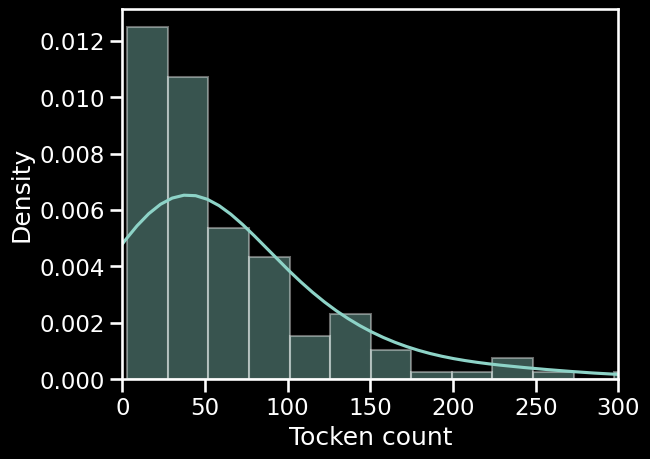

In [24]:
# 我们将看看标记化评论的长度分布，以便了解如何为标记化评论设置max_length。
#  使用Seaborn库的distplot()函数绘制标记化评论长度（即句子长度）的分布图。senten_len是包含句子长度的列表。
sns.distplot(senten_len)
# 使用Matplotlib库的xlim()函数设置x轴的范围。在这里，范围被设置为0到300，以便更清楚地观察长度在该范围内的句子分布情况。
plt.xlim([0, 300])
# 使用Matplotlib库的xlabel()函数设置x轴的标签为"Token count"，表示标记（token）的数量。
plt.xlabel('Tocken count')

In [25]:
# 200似乎是个不错的尺寸，继续前进。
max_len = 200

In [26]:
# 我们定义了一个类BertDataSet，其中Dataset是超类，并在其中覆盖theinit_、len和getitem__函数。
# 它将获得评论列表和相关的有毒标签（在本例中为6个标签），并创建标记ID和注意力掩码来区分评论和零填充。
# torch.tenor vs np.ndarray：
# 如果您只对矩阵执行数学运算的有效和简单的方法感兴趣，np.ndarray或torch.tenor可以互换使用。
# 然而，torch.tenors被设计用于梯度下降优化的上下文中，因此它们不仅包含具有数值的张量，而且（更重要的是）包含导致这些值的计算图。
# 然后使用该计算图（使用导数的链式规则）来计算损失函数w.r.t的导数，每个自变量用于计算损失。
# np.ndarray对象没有这个额外的“计算图”层，因此，在将torch.tenor转换为np.ndarray时，您必须使用detach()命令显式删除张量的计算图。

# 定义了一个名为BertDataSet的类，并继承了torch.utils.data.Dataset类。
# 这意味着BertDataSet类是一个PyTorch数据集类的子类，它需要实现__len__和__getitem__方法。
class BertDataSet(Dataset):

    # BertDataSet类的初始化方法。它接受两个参数：sentences是一个包含句子的列表或数组，toxic_labels是一个包含对应句子的标签的矩阵。
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        #target is a matrix with shape [#1 x #6(toxic, obscene, etc)]
        self.targets = toxic_labels.to_numpy()

    # 返回数据集中样本的数量，即句子的数量。
    def __len__(self):
        return len(self.sentences)
    
    # 它接受一个索引idx，并返回对应索引处的样本。
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        # 使用BERT分词器tokenizer对句子进行编码和处理。encode_plus()方法将句子转换为BERT模型需要的输入表示形式，
        # 并返回一个包含输入标记（token）ID、注意力掩码（attention mask）等信息的字典。
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        # 将输入标记（token）的ID序列转换为torch.tensor张量，并指定数据类型为torch.long。
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        # 将注意力掩码（attention mask）序列转换为torch.tensor张量，并指定数据类型为torch.long。
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        # 获取在索引idx处的标签，并将其转换为torch.tensor张量，并指定数据类型为torch.float。
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        # 返回一个字典，包含输入标记（token）ID、注意力掩码（attention mask）和对应的标签。这个字典将作为一个样本被返回给模型进行训练或推理。
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

In [27]:
train_dataset = BertDataSet(p_train['clean_text'], p_train[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])
valid_dataset = BertDataSet(p_valid['clean_text'], p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])

In [28]:
# 让我们看看数据集中有什么：
for a in train_dataset:
    print(a)
    break

{'ids': tensor([  101, 10136,  2246,  2246,  1124,  2697,  1142,  3582,  5922,   146,
         1306,  9321,  5342,  1114,  5749,  2037,  1356, 11390,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,

In [29]:
# 现在我们为trainig集和验证集设置批量大小。较大的批量大小有助于加快计算速度。
# 然而，结果证实，在给定的计算成本下，使用小批量大小可以实现最佳泛化性能。
# 在所有情况下，批量大小为32或更小的情况下都能获得最佳结果。通常小至2或4的小批量大小会提供最佳结果。
train_batch = 32
valid_batch = 32

In [30]:
# 在下面的代码中pin_memory=True to a DataLoader会自动将获取的数据张量放入固定内存，从而能够更快地将数据搬迁到支持CUDA的GPU。
# num_workers为正整数将打开具有指定数量的加载器工作进程的多进程数据加载
# train_dataset: 训练数据集，即之前创建的train_dataset对象，其中包含了经过处理的训练数据和标签。
# batch_size: 批量大小，指定每个批次中包含的样本数量。
# pin_memory=True: 设置为True时，将数据存储在固定内存中，可以加速数据传输。
# num_workers=4: 指定用于加载数据的子进程数量，这可以加速数据加载过程。
# shuffle=True: 设置为True时，每个迭代器返回的批次将是随机排列的，用于在训练过程中对样本进行随机采样。
train_dataloader = DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 4, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 4, shuffle = False)

In [31]:
%%time
for a in train_dataloader:
    print(a)
    print('id shape in data laoder is',a['ids'].shape)
    break
# 在这里，我们可以检查数据记录器内部

{'ids': tensor([[  101,  1192,  1169,  ...,     0,     0,     0],
        [  101,  1573,  2158,  ...,     0,     0,     0],
        [  101, 20173,  4960,  ...,     0,     0,     0],
        ...,
        [  101,  8790, 16409,  ...,     0,     0,     0],
        [  101, 19585, 26918,  ...,  1132,  7173,   102],
        [  101,  2181,  1122,  ...,  1775,  3118,   102]]), 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'toxic_label': tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 

# 5.BERT Modeling

In [32]:
# 为了更快的计算，让我们设置设备cuda（如果可用）。
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [33]:
%%time
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 6)
model.to(device)
model.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 766 ms, sys: 915 ms, total: 1.68 s
Wall time: 4.49 s


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [34]:
# 用for循环迭代训练数据加载器train_dataloader，每次迭代获取一个批次的数据。
for a in train_dataloader:
    # 从批次数据a中获取输入标记（token）ID张量，并将其移动到指定的设备上（通常是GPU）。这里假设模型的输入是ids。
    ids = a['ids'].to(device)
    # 从批次数据a中获取注意力掩码（attention mask）张量，并将其移动到指定的设备上。这里假设模型的输入是mask。
    mask = a['mask'].to(device)
    # 将输入数据ids和mask传递给模型进行前向推理，得到输出结果。这里假设模型是一个可调用对象，并且采用了输入为ids和mask的调用方式。
    output = model(ids, mask)
    break

In [35]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.3815,  0.4464,  0.0939, -0.7846, -0.3709, -0.4193],
        [ 0.7494,  0.3200,  0.1359, -0.8429, -0.2012, -0.1883],
        [ 0.6118,  0.3596,  0.1714, -0.6639, -0.3607, -0.3531],
        [ 0.6472,  0.2263, -0.0137, -0.3388, -0.4653, -0.0912],
        [ 0.8247,  0.3835,  0.3213, -0.7171, -0.1386,  0.1744],
        [ 0.3072,  0.0400,  0.1078, -0.6001, -0.2020,  0.0542],
        [ 0.5474,  0.1405,  0.1599, -0.4739, -0.1076, -0.3854],
        [ 0.5317,  0.3002,  0.1793, -0.4504, -0.2345, -0.0555],
        [ 0.6668,  0.5423,  0.5865, -0.4796, -0.1606, -0.0569],
        [ 0.5281,  0.3104,  0.1427, -0.5065, -0.1396,  0.0204],
        [ 0.9418,  0.2514,  0.4774, -0.6493,  0.0740, -0.3834],
        [ 0.3557,  0.7851,  0.3501, -0.3863, -0.2687, -0.1735],
        [ 0.2585,  0.3359,  0.1473, -0.2119, -0.3774, -0.2720],
        [ 0.9064,  0.3391,  0.2519, -0.4020, -0.4351, -0.0032],
        [ 0.6799,  0.0684,  0.2877, -0.7487, -0.2911, -0.3567

## 5.1 Softmax和Sigmoid
为了得到输出概率，我们应该使用sigmoid函数。这可以在模型中完成，也可以像这里一样应用于模型的输出。我第一次犯了错误，使用了softmax函数。然而，在我们的例子中，评论可以同时被归类为有毒、淫秽和侮辱。因此，这不是multi-classficationm，因此，这不适用。  
以下是softmax函数和sigmoid函数之间差异的总结。  
Softmax功能：  
    用于物流回归模型中的Multi-classification  
    概率和为1  
Sigmoid功能：  
    用于Logistic回归模型中的二进制分类  
    概率和不需要是1  
要了解更多关于他们的信息，你可以阅读以下内容：https://medium.com/arteos-ai/the-differences-between-sigmoid-and-softmax-activation-function-12adee8cf322

In [36]:
# 使用了PyTorch中的softmax函数，对模型的输出output['logits']进行概率归一化。output['logits']是一个张量，
# 其形状可能是(batch_size, num_classes)，其中batch_size是批次大小，num_classes是类别数量。
# dim=1参数指定沿着第1个维度进行softmax操作，即对每个样本的输出进行概率归一化。这样，函数将对每个样本的输出值进行softmax处理，
# 并返回一个与output['logits']形状相同的张量，其中每个元素表示对应类别的概率值。
func.softmax(output['logits'], dim = 1)

tensor([[0.2470, 0.2635, 0.1852, 0.0770, 0.1164, 0.1109],
        [0.3151, 0.2051, 0.1706, 0.0641, 0.1218, 0.1234],
        [0.2891, 0.2246, 0.1861, 0.0807, 0.1093, 0.1102],
        [0.2983, 0.1958, 0.1540, 0.1113, 0.0981, 0.1425],
        [0.2972, 0.1911, 0.1796, 0.0636, 0.1134, 0.1551],
        [0.2291, 0.1754, 0.1876, 0.0925, 0.1377, 0.1778],
        [0.2764, 0.1840, 0.1876, 0.0996, 0.1436, 0.1088],
        [0.2570, 0.2039, 0.1806, 0.0962, 0.1194, 0.1428],
        [0.2472, 0.2182, 0.2281, 0.0786, 0.1081, 0.1199],
        [0.2529, 0.2034, 0.1720, 0.0899, 0.1297, 0.1522],
        [0.3312, 0.1661, 0.2082, 0.0675, 0.1391, 0.0880],
        [0.1949, 0.2994, 0.1938, 0.0928, 0.1044, 0.1148],
        [0.2120, 0.2290, 0.1897, 0.1324, 0.1122, 0.1247],
        [0.3310, 0.1877, 0.1720, 0.0895, 0.0865, 0.1333],
        [0.3134, 0.1700, 0.2117, 0.0751, 0.1187, 0.1111],
        [0.3241, 0.2148, 0.1392, 0.0941, 0.1260, 0.1017],
        [0.2463, 0.2143, 0.2231, 0.0834, 0.1337, 0.0993],
        [0.253

In [37]:
# 使用softmax函数对模型的输出output['logits']进行概率归一化，得到每个类别的概率分布。
# output['logits']是模型的原始输出，经过softmax处理后，output_probs将包含每个类别的概率值。
output_probs = func.softmax(output['logits'], dim = 1)
# 使用torch.max函数计算概率分布中的最大概率及其对应的索引。output_probs是一个张量，其形状可能是(batch_size, num_classes)，
# 其中batch_size是批次大小，num_classes是类别数量。dim=1参数指定沿着第1个维度进行计算，即对每个样本的概率分布计算最大值。
torch.max(output_probs, dim = 1)

torch.return_types.max(
values=tensor([0.2635, 0.3151, 0.2891, 0.2983, 0.2972, 0.2291, 0.2764, 0.2570, 0.2472,
        0.2529, 0.3312, 0.2994, 0.2290, 0.3310, 0.3134, 0.3241, 0.2463, 0.2539,
        0.2651, 0.2732, 0.3260, 0.2956, 0.3102, 0.2928, 0.2968, 0.3092, 0.3056,
        0.2964, 0.3150, 0.2740, 0.2899, 0.3102], grad_fn=<MaxBackward0>),
indices=tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]))

# 6.Functions for training and validating
## 6.1 Setting up some parameters

In [38]:
# 定义了训练的总轮数（epoch）。在训练过程中，将对数据集进行多次迭代，每次迭代称为一个轮数。
epochs = 5
# 定义了学习率（learning rate）。学习率控制了模型参数更新的步长，即每次更新时参数所改变的大小。
LR = 2e-5 #Learning rate
# 创建了一个优化器对象，用于更新模型的参数。
# model.parameters(): 指定需要更新的模型参数。model是之前定义的模型对象，调用parameters()方法可以获取到模型的可训练参数。
# LR: 学习率，即参数更新的步长。
# betas=(0.9, 0.999): AdamW优化器中的beta系数，用于计算梯度一阶矩和二阶矩的移动平均。
# weight_decay=1e-2: 权重衰减因子，用于对模型参数进行L2正则化，以防止过拟合。
# correct_bias=False: 是否对偏置项进行修正。
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2, correct_bias = False)

In [39]:
# 对于总训练时间的10%，我们使用上面设置的学习率参数。然后我们逐渐将学习率降低到零。

# 计算了训练过程中的总步数（train_steps）。len(train)表示训练集的样本数量，epochs表示训练的总轮数，
# train_batch表示每个训练批次的样本数量。通过这个计算，可以确定在整个训练过程中需要执行多少个训练步骤。
train_steps = int((len(train) * epochs)/train_batch)
# 计算了学习率调度器中的预热步数num_steps，train_steps表示总步数，0.1表示预热步数占总步数的比例
num_steps = int(train_steps * 0.1)
# 创建了一个学习率调度器（scheduler），使用了线性预热策略。
# optimizer是之前定义的优化器对象。num_steps表示预热步数，train_steps表示总步数。
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


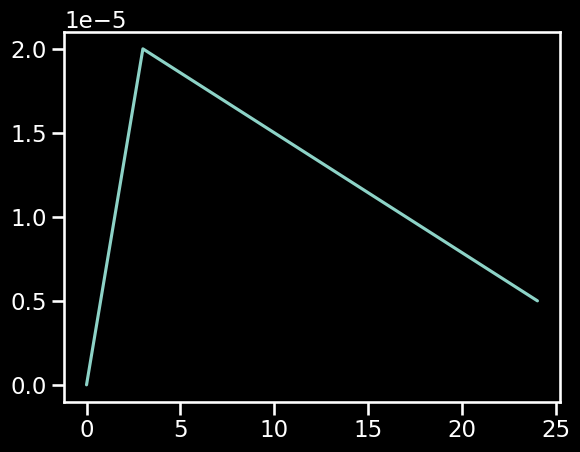

In [40]:
# 创建一个空列表le，用于存储每个训练步骤的学习率。
le = []
# 使用for循环迭代epochs次，表示训练的总轮数。使用tqdm函数可以在循环中显示一个进度条，以便实时跟踪训练进度。
for b in tqdm(range(epochs)):
    # 使用嵌套的for循环迭代训练数据加载器train_dataloader，获取每个批次的数据进行训练。
    for a in train_dataloader:
        # 获取当前训练步骤的学习率，并将其添加到le列表中。scheduler.get_last_lr()返回当前学习率的值。
        le.append(scheduler.get_last_lr())
        # 调用学习率调度器的step()方法，更新学习率。
        scheduler.step()
# np.arange(len(le))创建一个与le列表长度相同的横坐标，表示训练步骤的索引。然后，使用plt.plot函数绘制学习率曲线。
plt.plot(np.arange(len(le)), le)

In [41]:
# 创建了一个二分类任务中常用的损失函数BCEWithLogitsLoss。
# 该损失函数结合了sigmoid激活函数和二元交叉熵损失，适用于二分类问题。它可以直接在模型的输出上计算损失，无需对输出进行额外的激活函数处理。
loss_fn = nn.BCEWithLogitsLoss()
# 将损失函数对象移动到指定的设备上进行计算。
# device是之前定义的设备对象，可以是CPU或GPU。将损失函数移动到设备上，可以确保在计算损失时使用与模型相同的设备。
loss_fn.to(device)

# 创建了一个梯度缩放器对象scaler，用于在混合精度训练中缩放和反缩放梯度。
# torch.cuda.amp是PyTorch提供的用于混合精度训练的加速库。
scaler = torch.cuda.amp.GradScaler()

## 6.2Training function

amp代表自动混合精度。  
要了解有关自动广播的更多信息，请阅读此链接：https://pytorch.org/docs/stable/amp.html  
简而言之：自动转换的实例充当上下文管理器或装饰器，允许脚本区域以混合精度运行，其中一些操作使用torch. float32（浮点数）数据类型，而其他操作使用torch.float16（一半）。自动转换应该只包装网络的前向传递，包括损失计算。不建议自动转换下的向后传递。  

Python中的with语句用于异常处理，以使代码更清晰、更具可读性。它简化了文件流等常见资源的管理。这是了解更多信息的链接。
https://www.geeksforgeeks.org/with-statement-in-python/  

Non-Blocking允许您将计算和内存传输重叠到GPU。固定内存允许非阻塞调用实际上是非阻塞的。

为什么只使用var.detach().cpu().numpy()而不是var.numpy()？
因为我们得到了一个错误。这个选择背后的主要原因大概是为了避免混淆新来的人。不太熟悉requires_grad和cpu/gpu张量的人可能会来回使用numpy。例如，在最后一个张量上执行pytorch->numpy->pytorch并向后返回。这将毫无问题地向后返回，但不会一直到代码的第一部分，也不会引发任何错误。因此，选择强制用户分离（）以确保他们想要这样做，而不是错别字/其他库进行这种转换并破坏计算图。

optimizer.step(): 它根据当前梯度（存储在参数的. grad属性中）和更新规则执行参数更新。例如，SGD的更新规则定义在此处：
https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63

los.backward()多次调用.backward()会累积每个参数的梯度（通过加法）。这就是为什么您应该在每次.Step()调用后调用优化器.zero_grad()。请注意，在第一次.backward()调用之后，只有在执行另一个前向传递之后才能进行第二次调用。

In [42]:
# 您可以在下面的代码块中找到有关某些关键字的更多详细信息。
def training(train_dataloader, model, optimizer, scheduler):
    #  将模型设置为训练模式，以启用训练相关的功能
    model.train()
    # 启用CuDNN的自动调优机制，以提高训练速度。该语句是可选的，可以根据需要进行设置。
    torch.backends.cudnn.benchmark = True
    # 用于记录正确预测的数量。
    correct_predictions = 0
    
    # 使用for循环迭代训练数据加载器
    for a in train_dataloader:
        # 创建一个空列表losses，用于存储每个批次的损失值。
        losses = []
        # 将优化器中的梯度归零，以准备计算新一批数据的梯度。
        optimizer.zero_grad()
        # 使用自动混合精度上下文，将模型和数据转换为适当的精度进行计算。这可以提高训练速度并节省内存。
        with torch.cuda.amp.autocast():
            # 将输入数据ids移动到指定的设备上进行计算。
            ids = a['ids'].to(device, non_blocking = True)
            # 将输入数据mask移动到指定的设备上进行计算。
            mask = a['mask'].to(device, non_blocking = True) 
            # 将输入数据传递给模型进行前向传播，得到模型的输出。
            output = model(ids, mask)
            # 从模型的输出中提取logits，并将其转换为float32类型。
            output = output['logits'].squeeze(-1).to(torch.float32)
            # 将logits输入到sigmoid函数中，得到输出的概率值。
            output_probs = torch.sigmoid(output)
            # 据输出概率值，将概率大于0.5的判定为1，小于等于0.5的判定为0，得到预测结果。
            preds = torch.where(output_probs > 0.5, 1, 0)
            # 将目标标签数据toxic_label移动到指定的设备上进行计算。
            toxic_label = a['toxic_label'].to(device, non_blocking = True)
            # 计算模型输出与目标标签之间的损失，使用之前定义的损失函数loss_fn。 
            loss = loss_fn(output, toxic_label)            
            # 将当前批次的损失值添加到losses列表中。
            losses.append(loss.item())
            # 统计正确预测的数量，通过计算预测结果与目标标签相等的元素个数进行累加。
            correct_predictions += torch.sum(preds == toxic_label)
        # 将损失值进行梯度缩放并进行反向传播。这是混合精度训练中的一步，用于缩放梯度的值。
        scaler.scale(loss).backward()
        # 使用缩放后的梯度值来更新模型的参数。这是混合精度训练中的一步，用于更新模型参数。
        scaler.step(optimizer)
        # 新梯度缩放器的缩放因子。如果跳过了某些优化器步骤，则会相应地调整缩放因子，以减小它。
        # 如果连续出现未跳过的迭代次数，缩放因子将乘以增长因子，以增加它。
        scaler.update()
        # 更新学习率调度器，根据当前的迭代次数调整学习率。
        scheduler.step()
    # 计算所有批次的平均损失值。
    losses = np.mean(losses)
    # 将正确预测的数量从Tensor对象转换为NumPy数组。
    corr_preds = correct_predictions.detach().cpu().numpy()
    # 计算准确率，即正确预测的样本数除以总样本数的乘积。
    accuracy = corr_preds/(len(p_train)*6)
    # 返回训练过程中的平均损失值和准确率。
    return losses, accuracy

## 6.3 Gradient Scaling
如果特定操作的前向传递有float16输入，则该操作的后向传递将产生float16梯度。小幅度的梯度值可能无法在float16中表示。这些值将刷新到零（“下限溢位”），因此相应参数的更新将丢失。  
为了防止下限溢位，“梯度缩放”将网络的损耗乘以缩放因子，并对缩放后的损耗调用向后传递。然后，向后流经网络的梯度按相同的因子缩放。换句话说，梯度值具有更大的幅度，因此它们不会刷新为零。  
在优化器更新参数之前，每个参数的梯度（.grad属性）都应该未缩放，因此缩放因子不会干扰学习率。  
Step()执行以下两个操作：  
1.在内部调用unscale(优化器)(除非在迭代的前面显式地为优化器调用unscale())。  
2.如果未找到inf/NaN渐变，请使用未缩放的渐变调用优化器.Step()。否则，将跳过优化器.Step()以避免损坏参数。
## 6.4 Validating function


In [43]:
# 验证函数与训练函数非常相似。不同之处在于其中没有反向传播和参数优化。
def validating(valid_dataloader, model):
    # 将模型设置为评估模式，以禁用训练相关的功能，如批次归一化和Dropout。
    model.eval()
    # 用于记录正确预测的数量。
    correct_predictions = 0
    # 创建一个空列表all_output_probs，用于存储所有输出概率值。
    all_output_probs = []
    # 使用for循环迭代验证数据加载器valid_dataloader，获取每个批次的数据进行验证。
    for a in valid_dataloader:
        # 创建一个空列表losses，用于存储每个批次的损失值。
        losses = []
        # 将输入数据ids移动到指定的设备上进行计算。
        ids = a['ids'].to(device, non_blocking = True)
        # 将输入数据mask移动到指定的设备上进行计算。
        mask = a['mask'].to(device, non_blocking = True)
        # 将输入数据传递给模型进行前向传播，得到模型的输出。
        output = model(ids, mask)
        # 从模型的输出中提取logits，并将其转换为float32类型。
        output = output['logits'].squeeze(-1).to(torch.float32)
        # 将logits输入到sigmoid函数中，得到输出的概率值。
        output_probs = torch.sigmoid(output)
        # 根据输出概率值，将概率大于0.5的判定为1，小于等于0.5的判定为0，得到预测结果。
        preds = torch.where(output_probs > 0.5, 1, 0)
        # 将目标标签数据toxic_label移动到指定的设备上进行计算。
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        # 计算模型输出与目标标签之间的损失，使用之前定义的损失函数loss_fn。
        loss = loss_fn(output, toxic_label)
        # 将当前批次的损失值添加到losses列表中。
        losses.append(loss.item())
        # 将当前批次的输出概率值添加到all_output_probs列表中。
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        # 统计正确预测的数量，通过计算预测结果与目标标签相等的元素个数进行累加。
        correct_predictions += torch.sum(preds == toxic_label)
        # 将正确预测的数量从Tensor对象转换为NumPy数组。
        corr_preds = correct_predictions.detach().cpu().numpy()
    # 计算所有批次的平均损失值。
    losses = np.mean(losses)
    # 将正确预测的数量从Tensor对象转换为NumPy数组。
    corr_preds = correct_predictions.detach().cpu().numpy()
    # 计算准确率，即正确预测的样本数除以总样本数的乘积。
    accuracy = corr_preds/(len(p_valid)*6)
    # 返回验证过程中的平均损失值、准确率和所有输出概率值。
    return losses, accuracy, all_output_probs

# 6.Training the model
## 6.1 Run training function

In [44]:
# 初始化一个变量best_score，用于记录最佳的验证损失值。将其初始值设置为一个较大的数，以确保第一个验证损失值一定能够更新best_score。
best_score = 1000
# 创建空列表用于存储每个epoch的训练准确率
train_accs = []
# 验证准确率
valid_accs = []
# 训练损失值
train_losses = []
# 验证损失值
valid_losses = []

# 使用for循环迭代epochs次，表示训练的总轮数。
for eboch in tqdm(range(epochs)):
    # 调用训练函数training，传入训练数据加载器train_dataloader、模型model、优化器optimizer和学习率调度器scheduler，
    # 并获取训练过程中的损失值和准确率。
    train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
    # 调用验证函数validating，传入验证数据加载器valid_dataloader和模型model，并获取验证过程中的损失值、准确率和输出概率值。
    valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
    # 打印训练损失值和训练准确率。
    print('train losses: %.4f' % train_loss, 'train accuracy: %.3f' % train_acc)
    #  打印验证损失值和验证准确率。
    print('valid losses: %.4f' % valid_loss, 'valid accuracy: %.3f' % valid_acc)
    # 将训练损失值和验证损失值添加到对应的列表中。
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # 将训练准确率和验证准确率添加到对应的列表中。
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    # 判断当前的验证损失值是否小于best_score
    if valid_loss < best_score:
        # 更新best_score为当前的验证损失值
        best_score = valid_loss
        # 打印提示信息"Found a good model!"，表示找到了一个性能更好的模型。
        print('Found a good model!')
        # 创建一个字典state，包含了模型的状态字典、优化器的状态字典和best_score的值。
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        # 使用torch.save函数将state保存到文件"best_model.pth"，以便后续使用。
        torch.save(state, 'best_model.pth')
    # 如果当前的验证损失值不小于best_score，则不执行任何操作，继续进行下一个epoch的训练。
    else:
        pass

  0%|          | 0/5 [00:00<?, ?it/s]

train losses: 0.6417 train accuracy: 0.526
valid losses: 0.6354 valid accuracy: 0.592
Found a good model!


 20%|██        | 1/5 [01:10<04:42, 70.74s/it]

train losses: 0.6283 train accuracy: 0.620
valid losses: 0.6279 valid accuracy: 0.604
Found a good model!


 60%|██████    | 3/5 [03:17<02:09, 64.68s/it]

train losses: 0.6265 train accuracy: 0.602
valid losses: 0.6279 valid accuracy: 0.604


 80%|████████  | 4/5 [04:12<01:00, 60.60s/it]

train losses: 0.6233 train accuracy: 0.605
valid losses: 0.6279 valid accuracy: 0.604


100%|██████████| 5/5 [05:10<00:00, 62.05s/it]

train losses: 0.6353 train accuracy: 0.606
valid losses: 0.6279 valid accuracy: 0.604


## 6.2 Plotting the results

Text(0.5, 0.98, 'Fold = 0')

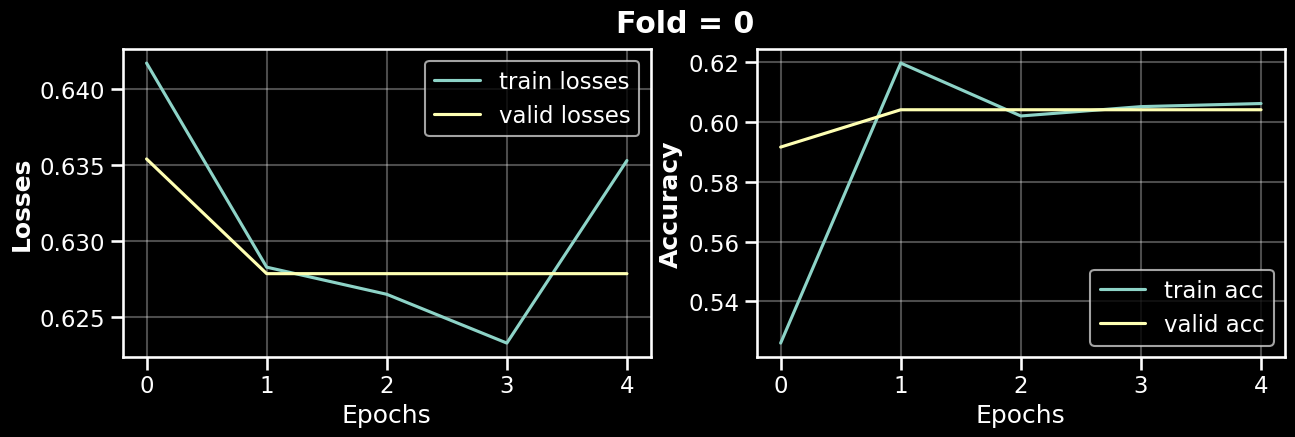

In [45]:
# 创建一个NumPy数组x，用于表示epoch的取值范围。
x = np.arange(epochs)
# 创建一个包含两个子图的图形，返回一个包含图形和子图对象的元组fig, ax。其中，fig是整个图形对象，ax是一个包含两个子图对象的数组。
fig, ax = plt.subplots(1, 2, figsize = (15,4))
# 在第一个子图中绘制训练损失值随着epoch的变化趋势，横坐标为x，纵坐标为train_losses。
ax[0].plot(x, train_losses)
# 在第一个子图中绘制验证损失值随着epoch的变化趋势，横坐标为x，纵坐标为valid_losses。
ax[0].plot(x, valid_losses)
# 设置第一个子图的纵轴标签为'Losses'，设置字体加粗。
ax[0].set_ylabel('Losses', weight = 'bold')
# 设置第一个子图的横轴标签为'Epochs'。
ax[0].set_xlabel('Epochs')
# 设置第一个子图的网格线，透明度为0.3。
ax[0].grid(alpha = 0.3)
# 设置第一个子图的图例，其中包含'train losses'和'valid losses'的标签。
ax[0].legend(labels = ['train losses', 'valid losses'])
# 在第二个子图中绘制训练准确率随着epoch的变化趋势，横坐标为x，纵坐标为train_accs。
ax[1].plot(x, train_accs)
# 在第二个子图中绘制验证准确率随着epoch的变化趋势，横坐标为x，纵坐标为valid_accs。
ax[1].plot(x, valid_accs)
# 设置第二个子图的纵轴标签为'Accuracy'，设置字体加粗。
ax[1].set_ylabel('Accuracy', weight = 'bold')
# 设置第二个子图的横轴标签为'Epochs'。
ax[1].set_xlabel('Epochs')
# 设置第二个子图的图例，其中包含'train acc'和'valid acc'的标签。
ax[1].legend(labels = ['train acc', 'valid acc'])
# 设置第二个子图的网格线，透明度为0.3。
ax[1].grid(alpha = 0.3)
# 设置整个图形的标题为'Fold = 0'，设置字体加粗。
fig.suptitle('Fold = 0', weight = 'bold') 

# 7.Evaluation
我们在本报告中使用auc作为评估指标。

In [46]:
# 调用验证函数validating，传入验证数据加载器valid_dataloader和模型model，并获取验证过程中的损失值、准确率和输出概率值。
valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
# 将验证输出概率值valid_probs转换为NumPy数组，并展平为一维数组。这样做的目的是为后续计算ROC曲线做准备。
valid_probs = np.asarray(valid_probs).flatten()
# 从验证数据中提取目标标签（toxic, severe_toxic, obscene, threat, insult, identity_hate），并将其转换为NumPy数组，并展平为一维数组。这样做的目的是为后续计算ROC曲线做准备。
y_valid = p_valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()
# 使用roc_curve函数计算ROC曲线的FPR、TPR和阈值。y_valid是真实标签，valid_probs是预测概率值。函数返回的fpr是FPR数组，tpr是TPR数组，_表示不使用阈值。
fpr, tpr, _ = roc_curve(y_valid, valid_probs)

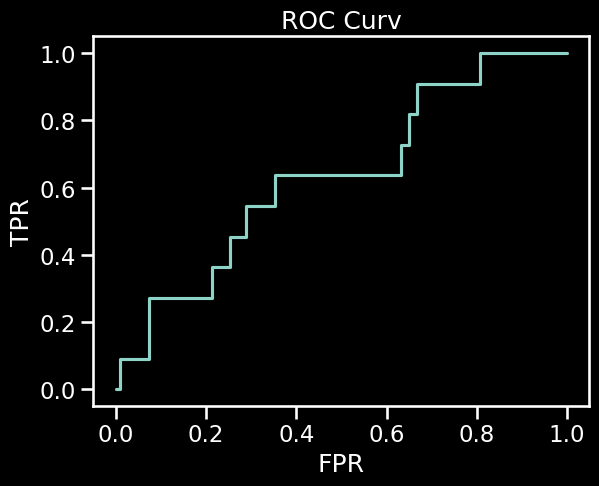

In [47]:
# 创建一个新的图形，并返回一个包含图形和轴对象的元组。其中，fig是图形对象，ax是轴对象。
fig, ax = plt.subplots()
# 在轴对象ax上绘制ROC曲线，横坐标为FPR，纵坐标为TPR。这里使用之前计算得到的FPR和TPR数组。
ax.plot(fpr, tpr)
# 设置图形的标题为'ROC Curve'。
ax.set_title('ROC Curv')
# 设置横轴标签为'FPR'，表示假正例率。
ax.set_xlabel('FPR')
# 设置纵轴标签为'TPR'，表示真正例率。
ax.set_ylabel('TPR')
# 显示图形。
plt.show()

In [48]:
# 计算由fpr和tpr定义的ROC曲线下的面积
auc(fpr, tpr)

0.6339817387852322

# PART 2
您可以从这里开始运行笔记本直到结束。我已经在这个笔记本中复制了第一部分的所有必要部分。这里的目标是展示模型如何为5个不同的折叠工作。纪元设置为5，并使用三角集的前2000行。随意更改这些参数，看看它如何影响准确性。